In [1]:
# %%
import numpy as np
from numpy.testing import assert_array_almost_equal
import torch
def build_uniform_P(size, noise):
    """ The noise matrix flips any class to any other with probability
    noise / (#class - 1).
    """

    assert(noise >= 0.) and (noise <= 1.)

    P = np.float64(noise) / np.float64(size - 1) * np.ones((size, size))
    np.fill_diagonal(P, (np.float64(1)-np.float64(noise))*np.ones(size))
    
    diag_idx = np.arange(size)
    P[diag_idx,diag_idx] = P[diag_idx,diag_idx] + 1.0 - P.sum(0)
    assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P

def build_pair_p(size, noise):
    assert(noise >= 0.) and (noise <= 1.)
    P = (1.0 - np.float64(noise)) * np.eye(size)
    for i in range(size):
        P[i,i-1] = np.float64(noise)
    assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P


def multiclass_noisify(y, P, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """

    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(P.sum(axis=1), np.ones(P.shape[1]))
    assert (P >= 0.0).all()

    m = y.shape[0]
    new_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, P[i, :], 1)[0]
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    sparserow=torch.LongTensor(sparse_mx.row).unsqueeze(1)
    sparsecol=torch.LongTensor(sparse_mx.col).unsqueeze(1)
    sparseconcat=torch.cat((sparserow, sparsecol),1)
    sparsedata=torch.FloatTensor(sparse_mx.data)
    return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))

def noisify(y, p_minus, p_plus=None, random_state=0):
    """ Flip labels with probability p_minus.
    If p_plus is given too, the function flips with asymmetric probability.
    """

    assert np.all(np.abs(y) == 1)

    m = y.shape[0]
    new_y = y.copy()
    coin = np.random.RandomState(random_state)

    if p_plus is None:
        p_plus = p_minus

    # This can be made much faster by tossing all the coins and completely
    # avoiding the loop. Although, it is not simple to write the asymmetric
    # case then.
    for idx in np.arange(m):
        if y[idx] == -1:
            if coin.binomial(n=1, p=p_minus, size=1) == 1:
                new_y[idx] = -new_y[idx]
        else:
            if coin.binomial(n=1, p=p_plus, size=1) == 1:
                new_y[idx] = -new_y[idx]

    return new_y

def noisify_with_P(y_train, nb_classes, noise, random_state=None,  noise_type='uniform'):

    if noise > 0.0:
        if noise_type=='uniform':
            print('Uniform noise')
            P = build_uniform_P(nb_classes, noise)
        elif noise_type == 'pair':
            print('Pair noise')
            P = build_pair_p(nb_classes, noise)
        else:
            print('Noise type have implemented')
        # seed the random numbers with #run
        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    else:
        P = np.eye(nb_classes)

    return y_train, P

def to_onehot(labels):
    class_size = labels.max() + 1
    onehot = np.eye(class_size)
    
    return onehot[labels]

# %%
import os
def load_emd(path, dataset):

    graph_embedding = np.genfromtxt(
            os.path.join(path,"{}.emb".format(dataset)),
            skip_header=1,
            dtype=float)
    embedding = np.zeros([graph_embedding.shape[0],graph_embedding.shape[1]-1])

    for i in range(graph_embedding.shape[0]):
        embedding[int(graph_embedding[i,0])] = graph_embedding[i,1:]
    
    return embedding
# %%
from sklearn.model_selection import train_test_split
def get_train_val_test(nnodes, val_size=0.1, test_size=0.8, stratify=None, seed=None):
    """This setting follows nettack/mettack, where we split the nodes
    into 10% training, 10% validation and 80% testing data

    Parameters
    ----------
    nnodes : int
        number of nodes in total
    val_size : float
        size of validation set
    test_size : float
        size of test set
    stratify :
        data is expected to split in a stratified fashion. So stratify should be labels.
    seed : int or None
        random seed

    Returns
    -------
    idx_train :
        node training indices
    idx_val :
        node validation indices
    idx_test :
        node test indices
    """

    assert stratify is not None, 'stratify cannot be None!'

    if seed is not None:
        np.random.seed(seed)

    idx = np.arange(nnodes)
    train_size = 1 - val_size - test_size
    idx_train_and_val, idx_test = train_test_split(idx,
                                                   random_state=None,
                                                   train_size=train_size + val_size,
                                                   test_size=test_size,
                                                   stratify=stratify)

    if stratify is not None:
        stratify = stratify[idx_train_and_val]

    idx_train, idx_val = train_test_split(idx_train_and_val,
                                          random_state=None,
                                          train_size=(train_size / (train_size + val_size)),
                                          test_size=(val_size / (train_size + val_size)),
                                          stratify=stratify)

    return idx_train, idx_val, idx_test


def accuracy(output, labels):
    """Return accuracy of output compared to labels.

    Parameters
    ----------
    output : torch.Tensor
        output from model
    labels : torch.Tensor or numpy.array
        node labels

    Returns
    -------
    float
        accuracy
    """
    if not hasattr(labels, '__len__'):
        labels = [labels]
    if type(labels) is not torch.Tensor:
        labels = torch.LongTensor(labels)
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [2]:
from __future__ import print_function, division
import argparse
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
from utils import _rank2_trace, _rank2_diag, load_data_from_mat, load_graph, load_data, load_graph_np, visualize_cluster
from GNN import GNNLayer
from evaluation import eva, eva_return
from collections import Counter
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [3]:
from scipy.special import softmax

def propagate(adj, alpha, label, class_num, iter_num):
    if label.shape[1] == 1:
        dense_label = np.zeros([label.shape[0], class_num])
        for i in range(label.shape[0]):
            dense_label[i, label[i, 0]] = 1
    else:
        dense_label = label
    
    H = dense_label
    Z = dense_label
    for i in range(iter_num):
        Z = (1 - alpha) * adj * Z + alpha * H
    Z = softmax(Z, axis=1)
    
    return Z

In [4]:
# class GAE(nn.Module):
    
#     def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
#                  n_input, n_z):
#         super(GAE, self).__init__()
#         self.enc_1 = GNNLayer(n_input, n_enc_1)
#         self.enc_2 = GNNLayer(n_enc_1, n_enc_2)
#         self.enc_3 = GNNLayer(n_enc_2, n_enc_3)
#         self.z_layer = Linear(n_enc_3, n_z)

#         self.dec_1 = Linear(n_z, n_dec_1)
#         self.dec_2 = Linear(n_dec_1, n_dec_2)
#         self.dec_3 = Linear(n_dec_2, n_dec_3)
#         self.x_bar_layer = Linear(n_dec_3, n_input)

#     def forward(self, x, adj):
#         enc_h1 = F.relu(self.enc_1(x, adj))
#         enc_h2 = F.relu(self.enc_2(enc_h1, adj))
#         enc_h3 = F.relu(self.enc_3(enc_h2, adj))
#         z = self.z_layer(enc_h3)

#         dec_h1 = F.relu(self.dec_1(z))
#         dec_h2 = F.relu(self.dec_2(dec_h1))
#         dec_h3 = F.relu(self.dec_3(dec_h2))
#         x_bar = self.x_bar_layer(dec_h3)

#         return x_bar, enc_h1, enc_h2, z


class GAE(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_dec_1, n_dec_2,
                 n_input, n_z):
        super(GAE, self).__init__()
        self.enc_1 = GNNLayer(n_input, n_enc_1)
        self.enc_2 = GNNLayer(n_enc_1, n_enc_2)
        self.z_layer = Linear(n_enc_2, n_z)

        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.x_bar_layer = Linear(n_dec_2, n_input)

    def forward(self, x, adj):
        enc_h1 = F.relu(self.enc_1(x, adj))
        enc_h2 = F.relu(self.enc_2(enc_h1, adj))
        z = self.z_layer(enc_h2)

        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        x_bar = self.x_bar_layer(dec_h2)

        return x_bar, enc_h1, enc_h2, z


class SDCN(nn.Module):

#     def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
#                 n_input, n_z, n_clusters, v=1):
#         super(SDCN, self).__init__()

#         # autoencoder for intra information
#         self.gae = GAE(
#             n_enc_1=n_enc_1,
#             n_enc_2=n_enc_2,
#             n_enc_3=n_enc_3,
#             n_dec_1=n_dec_1,
#             n_dec_2=n_dec_2,
#             n_dec_3=n_dec_3,
#             n_input=n_input,
#             n_z=n_z)
        
#         self.gae_momt = GAE(
#             n_enc_1=n_enc_1,
#             n_enc_2=n_enc_2,
#             n_enc_3=n_enc_3,
#             n_dec_1=n_dec_1,
#             n_dec_2=n_dec_2,
#             n_dec_3=n_dec_3,
#             n_input=n_input,
#             n_z=n_z)
    def __init__(self, n_enc_1, n_enc_2, n_dec_1, n_dec_2,
                n_input, n_z, n_clusters, v=1):
        super(SDCN, self).__init__()

        # autoencoder for intra information
        self.gae = GAE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_input=n_input,
            n_z=n_z)
        
        self.gae_momt = GAE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_input=n_input,
            n_z=n_z)
        
        self.gae.load_state_dict(torch.load(args.pretrain_path, map_location='cpu'))
        
#         mlp_projection = True
#         if mlp_projection:
#             dim_mlp = self.gae.z_layer.weight.shape[1]
#             self.gae.z_layer = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.gae.z_layer)
#             self.gae_momt.z_layer = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.gae_momt.z_layer)
        
        for param_ori, param_momt in zip(self.gae.parameters(), self.gae_momt.parameters()):
            param_momt.data.copy_(param_ori.data)  # initialize
            param_momt.requires_grad = False  # not update by gradient
        
        # degree
        self.v = v
        self.m = 0.9
        
    @torch.no_grad()
    def _momentum_update_momt_encoder(self):
        """
        Momentum update 
        """
        for param_ori, param_momt in zip(self.gae.parameters(), self.gae_momt.parameters()):
            param_momt.data = param_momt.data * self.m + param_ori.data * (1. - self.m)
    
    def forward(self, x, adj):

        x_bar, tra1, tra2, z = self.gae(x, adj)
        
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_momt_encoder()  # update the momentum encoder
            _, _, _, z_momt = self.gae_momt(x, adj)

        return x_bar, z, z_momt

In [5]:
parser = argparse.ArgumentParser(description='train', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--name', type=str, default='dblp')
parser.add_argument('--k', type=int, default=3)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--n_clusters', default=3, type=int)
parser.add_argument('--n_z', default=200, type=int)
parser.add_argument('--pretrain_path', type=str, default='pkl')
args = parser.parse_args(['--name', 'cite'])
args.cuda = torch.cuda.is_available()

args.cuda = False

print("use cuda: {}".format(args.cuda))
device = torch.device("cuda" if args.cuda else "cpu")

args.pretrain_path = 'data/{}.pkl'.format(args.name + '_new_500_500_200_6786_lr5e-4')
dataset = load_data(args.name)

if args.name == 'usps':
    args.n_clusters = 10
    args.n_input = 256

if args.name == 'hhar':
    args.k = 5
    args.n_clusters = 6
    args.n_input = 561

if args.name == 'reut':
    args.lr = 1e-4
    args.n_clusters = 4
    args.n_input = 2000

if args.name == 'acm':
    args.k = None
    args.n_clusters = 3
    args.n_input = 1870

if args.name == 'dblp':
    args.k = None
    args.n_clusters = 4
    args.n_input = 334

if args.name == 'cite':
    args.lr = 1e-4
    args.k = None
    args.n_clusters = 6
    args.n_input = 3703


use cuda: False


In [6]:
import process
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
adj_new, features, labels, idx_train, idx_val, idx_test = process.load_data('citeseer')

def evaluation(adj, data, model, idx_train, idx_test, out_id=3):
    clf = LogisticRegression(random_state=0, max_iter=2000)
#     clf_MLP = MLPClassifier(random_state=1, max_iter=2000, hidden_layer_sizes=(250,),solver='sgd', 
#                             learning_rate='adaptive',
#                            learning_rate_init = 0.01
#                            )
    clf_MLP = MLPClassifier(random_state=1, max_iter=800, hidden_layer_sizes=(250,))
    with torch.no_grad():
        out = model.gae(data, adj)
        embeds = out[out_id]
        train_embs = embeds[idx_train, :] 
        test_embs = embeds[idx_test, :]
        num_classes = 6

        train_label_only = y[idx_train]-1
        ptb = 0.2
        noise_type = 'uniform'
        noise_y, P = noisify_with_P(train_label_only, num_classes, ptb, 10, noise_type) 

        
        train_labels = torch.Tensor(noise_y+1)
        test_labels = torch.Tensor(y[idx_test])
#     clf.fit(train_embs, train_labels)
    clf_MLP.fit(train_embs, train_labels)
    pred_test_labels = clf_MLP.predict(test_embs)
    return accuracy_score(test_labels, pred_test_labels), pred_test_labels

In [7]:
# model = SDCN(500, 500, 2000, 2000, 500, 500,
#             n_input=args.n_input,
#             n_z=args.n_z,
#             n_clusters=args.n_clusters,
#             v=1.0).to(device)
model = SDCN(500, 500, 500, 500,
            n_input=args.n_input,
            n_z=args.n_z,
            n_clusters=args.n_clusters,
            v=1.0).to(device)
print(model)

optimizer = Adam(model.parameters(), lr=args.lr)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

# KNN Graph
adj_dense, adj = load_graph(args.name, args.k)
adj_dense_np, adj_np = load_graph_np(args.name, args.k)
# adj = adj.cuda()
# adj_dense = adj_dense.cuda()

# cluster parameter initiate
data = torch.Tensor(dataset.x).to(device)
y = dataset.y
with torch.no_grad():
    _, _, _, z_momt = model.gae(data, adj)

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(z_momt.data.cpu().numpy())
y_pred_last = y_pred
eva(y, y_pred, 'pae')

SDCN(
  (gae): GAE(
    (enc_1): GNNLayer()
    (enc_2): GNNLayer()
    (z_layer): Linear(in_features=500, out_features=200, bias=True)
    (dec_1): Linear(in_features=200, out_features=500, bias=True)
    (dec_2): Linear(in_features=500, out_features=500, bias=True)
    (x_bar_layer): Linear(in_features=500, out_features=3703, bias=True)
  )
  (gae_momt): GAE(
    (enc_1): GNNLayer()
    (enc_2): GNNLayer()
    (z_layer): Linear(in_features=500, out_features=200, bias=True)
    (dec_1): Linear(in_features=200, out_features=500, bias=True)
    (dec_2): Linear(in_features=500, out_features=500, bias=True)
    (x_bar_layer): Linear(in_features=500, out_features=3703, bias=True)
  )
)
pae :acc 0.6772 , nmi 0.4112 , ari 0.4242 , f1 0.6346


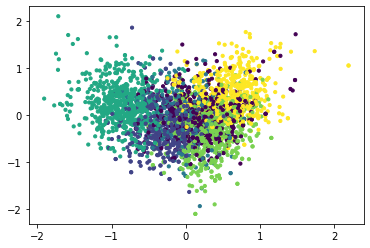

In [8]:
encoder_out = z_momt.data.cpu().numpy()
visualize_cluster(encoder_out, y_pred)

In [9]:
def get_proto_norm(feature, centroid):
    num_data = feature.shape[0]
    each_cluster_num = np.zeros([args.n_clusters])
    for i in range(args.n_clusters):
        each_cluster_num[i] = np.sum(init_labels==i)
    proto_norm_term = np.zeros([args.n_clusters])
    for i in range(args.n_clusters):
        norm_sum = 0
        for j in range(num_data):
            if init_labels[j] == i:
                norm_sum = norm_sum + LA.norm(feature[j] - ori_center[i], 2)
        proto_norm_term[i] = norm_sum / (each_cluster_num[i] * np.log2(each_cluster_num[i] + 10))

    proto_norm_momt = torch.Tensor(proto_norm_term)
    return proto_norm_momt

In [10]:
# initialize label_momt
init_labels = kmeans.labels_
label_momt = torch.Tensor(init_labels).unsqueeze(1)
label_momt = label_momt.to(torch.int64)

# initialize centroid_momt
ori_center = kmeans.cluster_centers_
centroid_momt = torch.Tensor(ori_center)

In [11]:
label_kmeans = kmeans.labels_[:, np.newaxis]

label_propagated = propagate(adj_np, 0.1, label_kmeans, args.n_clusters, 10)

centers_propagated = np.dot(label_propagated.T, z_momt) / np.sum(label_propagated.T, axis = 1)[:, np.newaxis]

label_propagated_hard = np.argmax(label_propagated, axis=1)
label_propagated_hard = label_propagated_hard[:, np.newaxis]
label_momt = torch.Tensor(label_propagated_hard)
label_momt = label_momt.to(torch.int64)

In [12]:
label_propagated_new = propagate(adj_np, 0.1, label_kmeans, args.n_clusters, 5)
centers_propagated_new = np.dot(label_propagated_new.T, z_momt) / np.sum(label_propagated.T, axis = 1)[:, np.newaxis]

label_propagated_hard_new = np.argmax(label_propagated_new, axis=1)
label_propagated_hard_new = label_propagated_hard_new[:, np.newaxis]
label_momt_new = torch.Tensor(label_propagated_hard_new)
label_momt_new = label_momt_new.to(torch.int64)

In [13]:
proto_norm_momt = get_proto_norm(z_momt, centroid_momt)
centroid_momt_new = centroid_momt
proto_norm_momt_new = get_proto_norm(z_momt, centroid_momt_new)

In [14]:
def get_proto_loss(feature, centroid, label_momt, proto_norm_momt):
    
    feature_norm = torch.norm(feature, dim=-1)
    feature = torch.div(feature, feature_norm.unsqueeze(1))
    
    centroid_norm = torch.norm(centroid, dim=-1)
    centroid = torch.div(centroid, centroid_norm.unsqueeze(1))
    
    sim_zc = torch.matmul(feature, centroid.t())
    
    sim_zc_normalized = torch.div(sim_zc, proto_norm_momt)
    sim_zc_normalized = torch.exp(sim_zc_normalized)
    sim_2centroid = torch.gather(sim_zc_normalized, -1, label_momt) 
    sim_sum = torch.sum(sim_zc_normalized, -1, keepdim=True)
    sim_2centroid = torch.div(sim_2centroid, sim_sum)
    loss = torch.mean(sim_2centroid.log())
    loss = -1 * loss
    return loss

In [15]:
re_loss_history = []
proto_loss_history = []
proto_loss_history_new = []
loss_history = []
centroid_history = []
best_acc_clf = 0
best_acc_clt = 0


feats = []
y_predicts_clu = []
y_predicts_clf = []
for epoch in range(100):    
    x_bar, encoder_out, encoder_out_momt = model(data, adj)

    re_loss = F.mse_loss(x_bar, data)

    proto_loss = get_proto_loss(encoder_out, centroid_momt, label_momt, proto_norm_momt)
    proto_loss_new = get_proto_loss(encoder_out, centroid_momt_new, label_momt_new, proto_norm_momt_new)

    loss =  proto_loss + proto_loss_new
    
    re_loss_history.append(re_loss.data.cpu().detach().numpy())
    proto_loss_history.append(proto_loss.data.cpu().detach().numpy())
    loss_history.append(loss.data.cpu().detach().numpy())
    proto_loss_history_new.append(proto_loss_new.data.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    with torch.no_grad():
        x_bar, encoder_out, encoder_out_momt = model(data, adj)
        
        
        classification_acc, pred_test_clf = evaluation(adj, data, model, idx_train, idx_test, 2)
        y_predicts_clf.append(pred_test_clf)
        print('gnn classification accuracy:' + str(classification_acc))
        if classification_acc > best_acc_clf:
            best_acc_clf = classification_acc
        
        
        kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(encoder_out_momt.data.cpu().numpy())
        y_predicts_clu.append(y_pred)
        clustering_acc = eva_return(y, kmeans.labels_, str(epoch) + 'encoder')
        if clustering_acc > best_acc_clt:
            best_acc_clt = clustering_acc
    
        label_kmeans = kmeans.labels_[:, np.newaxis]

        label_propagated = propagate(adj_np, 0.1, label_kmeans, args.n_clusters, 10)
        
        label_propagated_new = propagate(adj_np, 0.1, label_kmeans, args.n_clusters, 5)
        
        centers_propagated = np.dot(label_propagated.T, encoder_out_momt) / np.sum(label_propagated.T, axis = 1)[:, np.newaxis]
        centers_propagated_new = np.dot(label_propagated_new.T, encoder_out_momt) / np.sum(label_propagated_new.T, axis = 1)[:, np.newaxis]
        
        label_propagated_hard = np.argmax(label_propagated, axis=1)
        label_propagated_hard = label_propagated_hard[:, np.newaxis]
        
        label_propagated_hard_new = np.argmax(label_propagated_new, axis=1)
        label_propagated_hard_new = label_propagated_hard_new[:, np.newaxis]
        
        label_momt = torch.Tensor(label_propagated_hard)
        label_momt = label_momt.to(torch.int64)
        
        label_momt_new = torch.Tensor(label_propagated_hard_new)
        label_momt_new = label_momt_new.to(torch.int64)

        centroid_momt = torch.Tensor(centers_propagated)
        
        centroid_momt_new = torch.Tensor(centers_propagated_new)

        proto_norm_momt = get_proto_norm(encoder_out_momt, centroid_momt)
        proto_norm_momt_new = get_proto_norm(encoder_out_momt, centroid_momt_new)
        feats.append(encoder_out.data.cpu().numpy())

print('Best gnn classification accuracy: ' + str(best_acc_clf))
print('Best encoder clustering accuracy: ' + str(best_acc_clt))

Uniform noise
Actual noise 0.14
gnn classification accuracy:0.576
0encoder :acc 0.6796 , nmi 0.4146 , ari 0.4269 , f1 0.6346
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.578
1encoder :acc 0.6766 , nmi 0.4120 , ari 0.4248 , f1 0.6341
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.586
2encoder :acc 0.6847 , nmi 0.4197 , ari 0.4367 , f1 0.6399
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.589
3encoder :acc 0.6895 , nmi 0.4287 , ari 0.4455 , f1 0.6450
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.591
4encoder :acc 0.6892 , nmi 0.4269 , ari 0.4460 , f1 0.6441
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.595
5encoder :acc 0.6958 , nmi 0.4366 , ari 0.4574 , f1 0.6508
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.6
6encoder :acc 0.6958 , nmi 0.4360 , ari 0.4570 , f1 0.6496
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.603
7encoder :acc 0.6994 , nmi 0.4416 , ari 0.4627 , f1 0.6529
Un

gnn classification accuracy:0.682
65encoder :acc 0.7057 , nmi 0.4496 , ari 0.4733 , f1 0.6582
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.675
66encoder :acc 0.7057 , nmi 0.4496 , ari 0.4733 , f1 0.6582
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.676
67encoder :acc 0.7048 , nmi 0.4487 , ari 0.4719 , f1 0.6574
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.677
68encoder :acc 0.7045 , nmi 0.4484 , ari 0.4713 , f1 0.6571
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.679
69encoder :acc 0.7039 , nmi 0.4475 , ari 0.4704 , f1 0.6565
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.679
70encoder :acc 0.7042 , nmi 0.4476 , ari 0.4706 , f1 0.6572
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.675
71encoder :acc 0.7039 , nmi 0.4475 , ari 0.4703 , f1 0.6569
Uniform noise
Actual noise 0.14
gnn classification accuracy:0.679
72encoder :acc 0.7039 , nmi 0.4473 , ari 0.4702 , f1 0.6569
Uniform noise
Actual noi

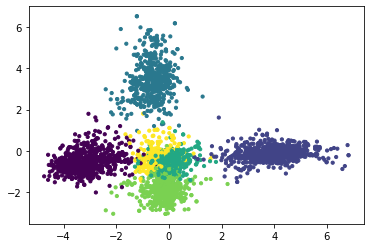

In [16]:
feature = encoder_out.data.cpu().numpy()
visualize_cluster(feature, y_pred)

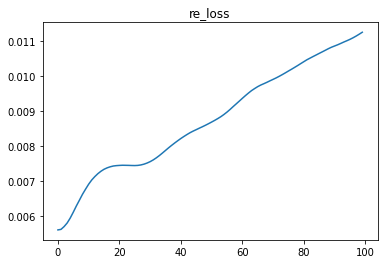

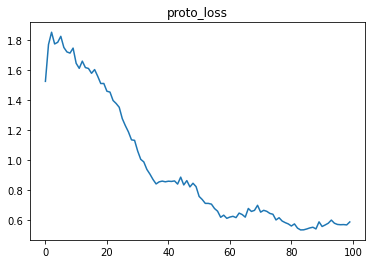

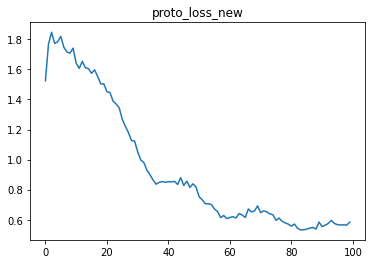

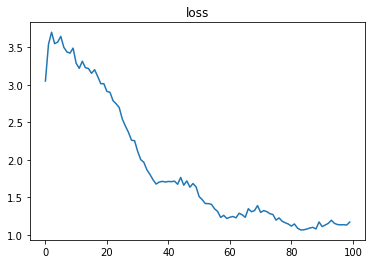

In [17]:


plt.plot(re_loss_history)
plt.title('re_loss')
plt.show()

plt.plot(proto_loss_history)
plt.title('proto_loss')
plt.show()

plt.plot(proto_loss_history_new)
plt.title('proto_loss_new')
plt.show()

plt.plot(loss_history)
plt.title('loss')
plt.show()

# plt.legend(["kl_loss", "ce_loss", "re_loss", "proto_loss", "loss"])

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 3327 samples in 0.039s...
[t-SNE] Computed neighbors for 3327 samples in 2.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3327
[t-SNE] Computed conditional probabilities for sample 2000 / 3327
[t-SNE] Computed conditional probabilities for sample 3000 / 3327
[t-SNE] Computed conditional probabilities for sample 3327 / 3327
[t-SNE] Mean sigma: 0.721876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.810753
[t-SNE] KL divergence after 700 iterations: 1.071150


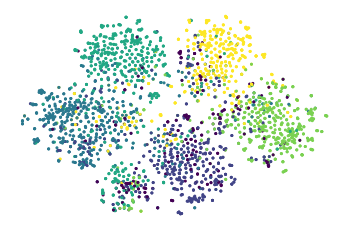

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=700)
tsne_results = tsne.fit_transform(feats[50])
plt.axis('off')
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, s=4)

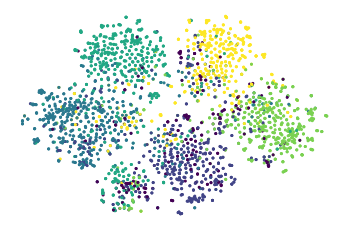

In [19]:
plt.axis('off')
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, s=4)
plt.savefig("figs/fig_cite_fix.pdf".format(144), bbox_inches="tight")


In [20]:
x = encoder_out.data.cpu().numpy()

In [21]:
c = centroid_momt.data.cpu().numpy()

In [22]:
from numpy import linalg as LA
n_node = x.shape[0]
d = np.zeros([n_node, 1])
for i in range(n_node):
    d[i] = LA.norm(x[i] - c[y_pred[i]], 2)
for i in range(n_node):
    d[i] = d[i]/np.max(d)

In [23]:
print(d)

[[0.2927213 ]
 [0.42157771]
 [0.2688747 ]
 ...
 [0.80601161]
 [1.        ]
 [1.        ]]


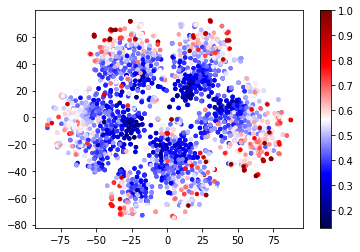

In [24]:

plt.scatter(tsne_results[:,0], tsne_results[:,1],c=d,cmap="seismic",s=12)
plt.colorbar()

plt.savefig("figs/red_plot.pdf".format(144), bbox_inches="tight")


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 3327 samples in 0.040s...
[t-SNE] Computed neighbors for 3327 samples in 2.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3327
[t-SNE] Computed conditional probabilities for sample 2000 / 3327
[t-SNE] Computed conditional probabilities for sample 3000 / 3327
[t-SNE] Computed conditional probabilities for sample 3327 / 3327
[t-SNE] Mean sigma: 0.721876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.662575
[t-SNE] KL divergence after 550 iterations: 1.154880


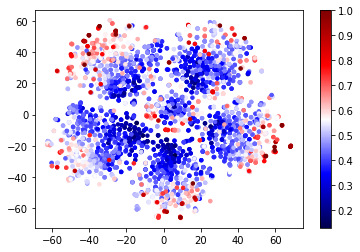

In [25]:
per = 15
niter = 550
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=per, n_iter=niter)
tsne_results = tsne.fit_transform(feats[50])
# plt.axis('off')
# plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, s=4)
from numpy import linalg as LA
n_node = x.shape[0]
d = np.zeros([n_node, 1])
for i in range(n_node):
    d[i] = LA.norm(x[i] - c[y_pred[i]], 2)
for i in range(n_node):
    d[i] = d[i]/np.max(d)
plt.scatter(tsne_results[:,0], tsne_results[:,1],c=d,cmap="seismic",s=12)
plt.colorbar()

plt.savefig("figs/red_plot_550.pdf".format(144), bbox_inches="tight")